In [1]:
import numpy as np
import scipy.stats as stats
from scipy.stats import rayleigh, norm, t
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Уровень доверия
alpha = 0.05

# Задаем параметры
sigma = 2
sample_sizes = [25, 100, 500]
num_samples = 800
num_intervals = 15

In [3]:
# Функция для вычисления статистического доверительного интервала на основе выборки
def empirical_confidence_interval(mu, alpha = 0.05):
    return mu - mu*alpha, mu + mu*alpha

# Функция для вычисления теоретического доверительного интервала
def theoretical_confidence_interval(mu, sigma, n, confidence):
    return stats.norm.interval(alpha=confidence, loc=mu, scale=sigma)

# Функция для вычисления F(x)
def calculate_cumulative_freq(bins, cumulative_freq, value):
    if value < bins[0]:
        return 0
    if value > bins[-1]:
        return 1
    idx = np.digitize(value, bins) - 1
    return cumulative_freq[idx]

In [4]:
# Генерируем выборки и вычисляем оценки математического ожидания
estimates = {}
samples = {}

for size in sample_sizes:
    estimates[size] = []
    samples[size] = []
    for _ in range(num_samples):
        sample = rayleigh.rvs(scale=sigma, size=size)
        estimate = np.mean(sample)
        estimates[size].append(estimate)
        samples[size].append(sample)

C:\Users\wizzt\AppData\Local\Temp\ipykernel_5784\2092328155.py:7: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  return stats.norm.interval(alpha=confidence, loc=mu, scale=sigma)


Выборка: 25
 left_cumulative_freq: 0.385
 right_cumulative_freq: 0.72125
Доверительная вероятность: 0.33624999999999994
Оценка мат. ожидания: 2.519705134265526
Статистический доверительный интервал: (2.3937198775522495, 2.6456903909788023)
Теоретический доврительный интервал: (2.4085032776655297, 2.630906990865522)
Расхождение: 13.294202601722377

Выборка: 100
 left_cumulative_freq: 0.20375
 right_cumulative_freq: 0.8837499999999999
Доверительная вероятность: 0.6799999999999999
Оценка мат. ожидания: 2.501832062857588
Статистический доверительный интервал: (2.3767404597147084, 2.6269236660004673)
Теоретический доврительный интервал: (2.3739246914644583, 2.6297394342507174)
Расхождение: 2.2014120215133595

Выборка: 500
 left_cumulative_freq: 0.0475
 right_cumulative_freq: 0.99375
Доверительная вероятность: 0.94625
Оценка мат. ожидания: 2.5092183148642144
Статистический доверительный интервал: (2.383757399121004, 2.634679230607425)
Теоретический доврительный интервал: (2.3962658557370418,

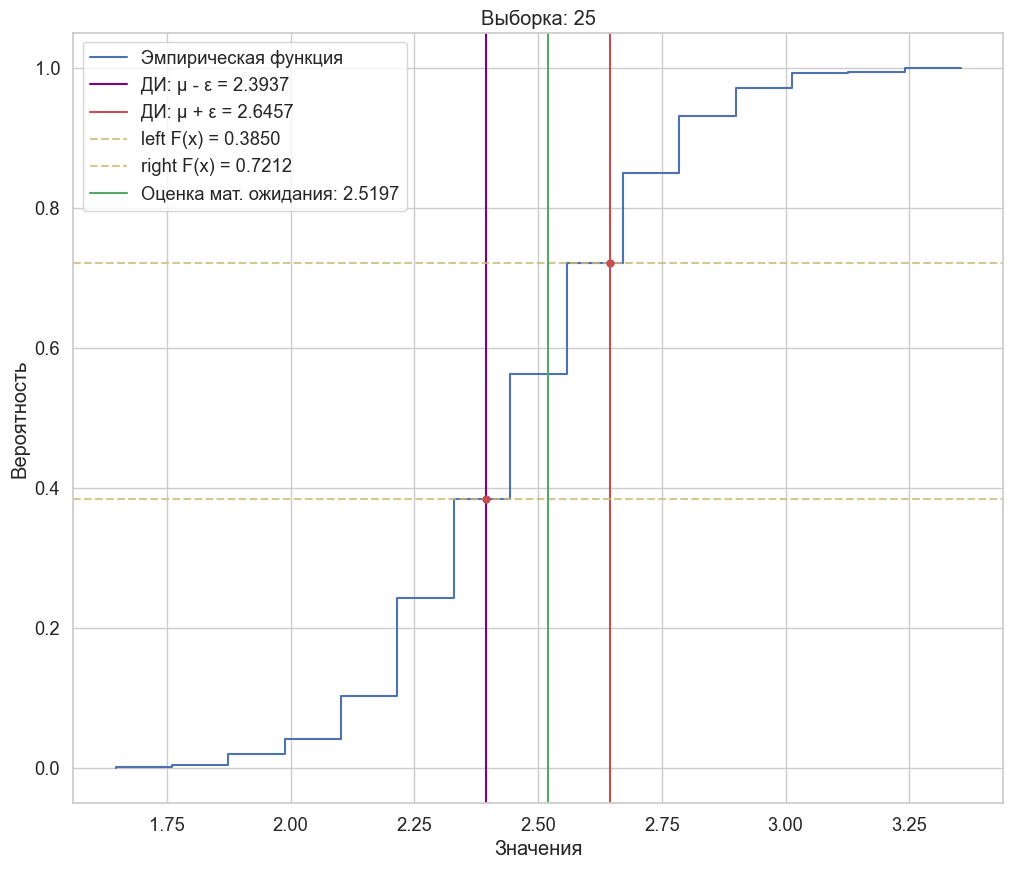

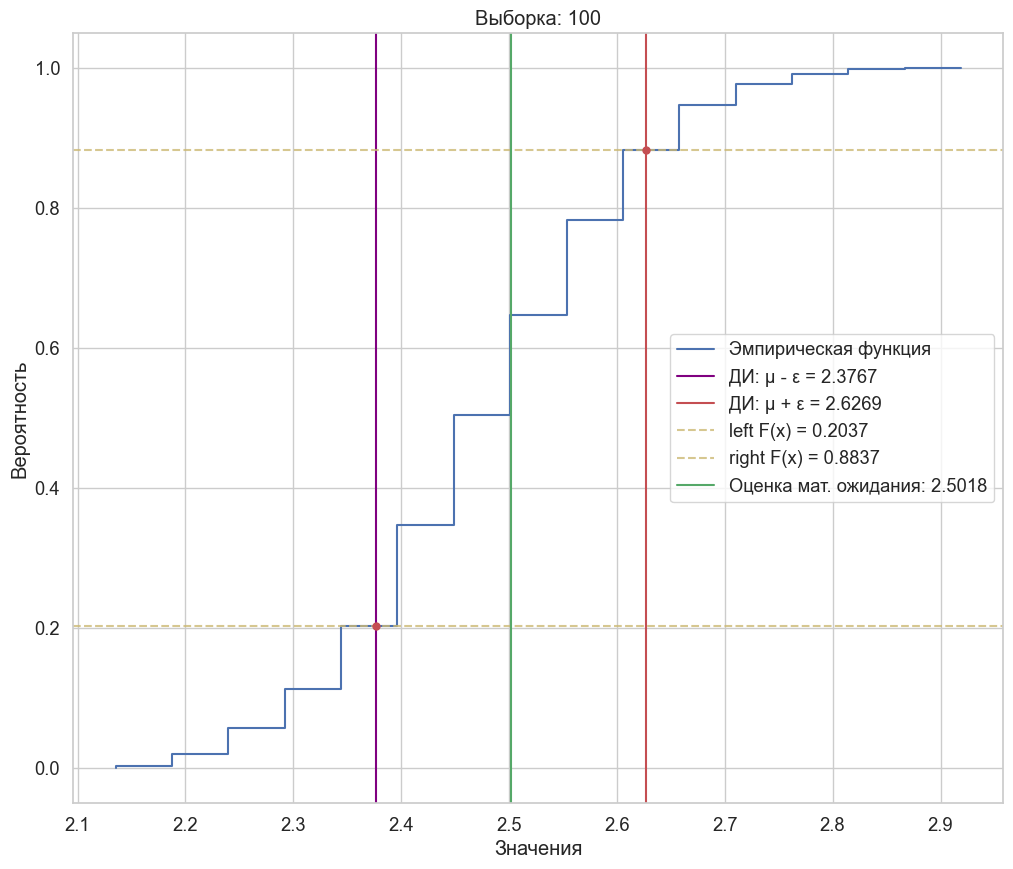

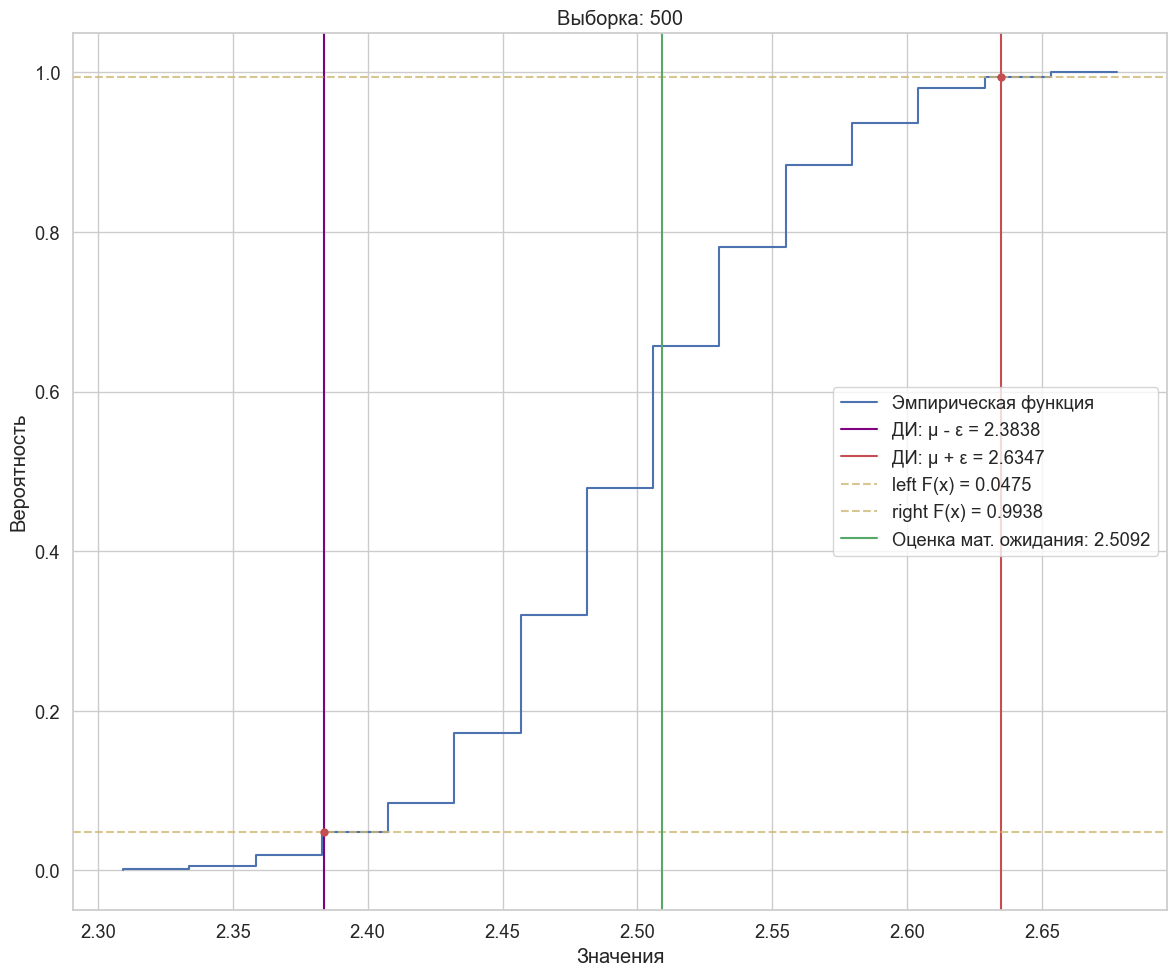

In [5]:
sns.set(style="whitegrid", font_scale=1.2)


scale_factor = 0.2  # Коэффициент масштабирования

for i, size in enumerate(sample_sizes):
    # Статистический ряд
    hist, bins = np.histogram(estimates[size], bins=num_intervals, density=False)
    frequencies = hist / np.sum(hist)
    cumulative_freq = np.cumsum(frequencies)
    cumulative_freq[-1] = 1
    
    
    # Сохраняем статистический ряд и функцию распределения в CSV файл
    data = {
        'Левая граница': bins[:-1],
        'Правая граница': bins[1:],
        'Кол-во попаданий': hist,
        'Частота': frequencies,
        'Функция распределения': cumulative_freq
    }
    
 
    n = len(samples[size])
    mean_estimates = np.mean(estimates[size])
    var_estimates = np.var(estimates[size], ddof=1)
    sigma_estimates = np.sqrt(var_estimates)
    se_y = np.sqrt(1 / n * var_estimates)
    

    empirical_ci = empirical_confidence_interval(mean_estimates)
    empirical_interval_length = (empirical_ci[1] - empirical_ci[0])/2
       
    left_cumulative_freq = calculate_cumulative_freq(bins, cumulative_freq, empirical_ci[0])
    right_cumulative_freq = calculate_cumulative_freq(bins, cumulative_freq, empirical_ci[1])
    

    confidence = right_cumulative_freq - left_cumulative_freq 
    
    theoretical_ci = theoretical_confidence_interval(mean_estimates, sigma_estimates, size, confidence)
    
    theoretical_interval_length = (theoretical_ci[1] - theoretical_ci[0])/2
    
    error = (abs(empirical_interval_length - theoretical_interval_length) / theoretical_interval_length) * 100
      
    print(f"Выборка: {size}")
    print(f" left_cumulative_freq: {left_cumulative_freq}")
    print(f" right_cumulative_freq: {right_cumulative_freq}")
    print(f"Доверительная вероятность: {confidence}")
    print(f"Оценка мат. ожидания: {mean_estimates}")
    print(f"Статистический доверительный интервал: {empirical_ci}")
    print(f"Теоретический доврительный интервал: {theoretical_ci}")
    #print(f"Theoretical Confidence Interval_Cтьюдента: {theoretical_ci_t}")
    print(f"Расхождение: {error}\n")
 
    df_stats = pd.DataFrame(data)
    df_stats.to_csv(f'stats_{size}.csv', index=False, header=f'Статистический ряд (Выборка: {size})')
    
    fig, ax = plt.subplots(figsize=(12,10))
    
    sorted_estimates = np.sort(estimates[size])
    ecdf = np.arange(1, len(sorted_estimates) + 1) / len(sorted_estimates)

    # Ступенчатая функция распределения
    x = np.repeat(bins, 2)[1:]
    y = np.concatenate(([0], np.repeat(cumulative_freq, 2)))
    ax.step(x, y, label='Эмпирическая функция', where='pre')

    # Нанесение вертикальной линии для empirical_ci
    ax.axvline(empirical_ci[0], color='purple', linestyle='-', label=f'ДИ: μ - ε = {empirical_ci[0]:.4f}')
    ax.axvline(empirical_ci[1], color='r', linestyle='-', label=f'ДИ: μ + ε = {empirical_ci[1]:.4f}')
    
    # Отметка горизонтальными линиями
    ax.axhline(left_cumulative_freq, color='y', linestyle='--', alpha=0.8, label=f'left F(x) = {left_cumulative_freq:.4f}')
    ax.axhline(right_cumulative_freq, color='y', linestyle='--', alpha=0.8, label=f'right F(x) = {right_cumulative_freq:.4f}')
    
    # Нанесение точек left_cumulative_freq и right_cumulative_freq
    ax.plot(empirical_ci[0], left_cumulative_freq, 'ro', markersize=5)
    ax.plot(empirical_ci[1], right_cumulative_freq, 'ro', markersize=5)

    # Нанесение вертикальной линии для mean_estimates
    ax.axvline(mean_estimates, color='g', linestyle='-', label=f'Оценка мат. ожидания: {mean_estimates:.4f}')

    ax.set_title(f"Выборка: {size}")
    ax.set_xlabel("Значения")
    ax.set_ylabel("Вероятность")
    ax.legend()
    
    plt.savefig(f'график_{size}.png', dpi=300)
    
plt.tight_layout()
plt.show()